In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import argparse
import json
import os
import pickle

import numpy as np
import tensorflow as tf

from arch.Sequencial_Dueling_DQN import SequencialDuelingDQN
from arch.simple_neural_network import NNRegressor
from database.MIMIC_cache_exp import MIMIC_cache_discretized_joint_exp_random_order
from policy_training_and_evaluation.run_sequential_dqn import process_exp_func
from utils.general import to_one_hot

In [3]:
def _plot_element(**kwargs):
    if 'title' in kwargs: plt.title(kwargs['title'], fontsize=20)
    if 'lower' in kwargs is not None and kwargs['upper'] is not None:
        plt.fill_between(kwargs['x'], kwargs['lower'], kwargs['upper'] , alpha=0.2)
    if 'xlabel' in kwargs: plt.xlabel(kwargs['xlabel'], fontsize=20)
    if 'ylabel' in kwargs: plt.ylabel(kwargs['ylabel'], fontsize=20)
    if 'xlim' in kwargs: plt.xlim(kwargs['xlim'])
    if 'ylim' in kwargs: plt.ylim(kwargs['ylim'])

def plot_hist_simple(data, **kwargs):
    plt.figure(figsize=[12,8])
    plt.hist(data)
    plt.grid(True)
    _plot_element(**kwargs)
    plt.show

def plot_scatter_simple(data1, data2, **kwargs):
    plt.figure(figsize=[12,8])
    plt.scatter(data1, data2)
    plt.grid(True)
    _plot_element(**kwargs)
    plt.show()

In [9]:
def reward_func(exp):
    # If mortality is 1, then encourage to increase probability.
    # If mortality is 0, be negative.
    information_gain = args.gain_coef * exp['prob_gain'] * (2 * exp['mortality'] - 1)
    if args.only_pos_reward:
        information_gain[information_gain < 0] = 0

    # action cost. Time pass cost is 0, others are 1
    time_pass = exp['actions'][:, -1]
    action_cost = 1 - time_pass

    rewards = information_gain + args.action_cost_coef * action_cost
    return rewards[:, None]  # Increase one dim


def parse_args(rand=False):

    parser = argparse.ArgumentParser(description='Regression based value estimator')

    # Experience --------------------------------
    parser.add_argument('--cache_dir', type=str,
                        default='../RL_exp_cache/1128-30mins-24hrs-20order-rnn-neg_sampled/')
    parser.add_argument('--policy_dir', type=str,
                        default='../models/dqn_mimic-1221_random_order_search-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-3-1-256-lr-0.0001-reg-0.0001-0.5-s-256-5000-i-50-500-3-1/')
    parser.add_argument('--reward_estimator_dir', type=str,
                        default='../models/rew_m_normal1217-hl1-hu512-lr1e-06-reg0.01-kp0.8-bs128-r1/')
    parser.add_argument('--normalized_state', type=int, default=1)
    
    args = parser.parse_args([])
    
    args.normalized_file = None
    if args.normalized_state:
        args.normalized_file = os.path.join(args.cache_dir, 'state_mean_and_std.csv')
        assert os.path.isfile(args.normalized_file)
    
    return args

In [10]:
seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)
args = parse_args()

tf.reset_default_graph()

with open(os.path.join(args.reward_estimator_dir, 'hyperparameters.pkl'), 'rb') as file:
    rew_estimator_hparams = pickle.load(file)

with open(os.path.join(args.reward_estimator_dir, 'results.pkl'), 'rb') as file:
    rew_estimator_training_results = pickle.load(file)
    # todo access mean and std of output and target of the training set form this file

reward_attributes = dict(gain_coef=1, action_cost_coef=5.0e-04, gamma=0.9,
                         pos_label_fold_coef=1.0, only_pos_reward=0)

with open(os.path.join(args.policy_dir, 'hyperparams.log'), 'r') as file:
    rl_attributes = json.load(file)['rl']
    # todo: access reward attributes from this file

with open(os.path.join(args.policy_dir, 'results.json'), 'r') as file:
    rl_training_results = json.load(file)

# set up cached experience
mimic_exp = MIMIC_cache_discretized_joint_exp_random_order(cache_dir=args.cache_dir)

# set up reward estimator ----------------
with tf.variable_scope('reward_model', reuse=tf.AUTO_REUSE):
    rew_estimator = NNRegressor(variable_scope='reward_model',
                                input_dim=rew_estimator_hparams.input_dim,
                                output_dim=rew_estimator_hparams.output_dim,
                                lr=rew_estimator_hparams.lr,
                                keep_prob=rew_estimator_hparams.keep_prob,
                                reg_constant=rew_estimator_hparams.reg_constant,
                                num_hidden_layers=rew_estimator_hparams.num_hidden_layers,
                                num_hidden_units=rew_estimator_hparams.num_hidden_units,
                                normalized_file=args.normalized_file, log=print)

# set up trained policy ----------------
with tf.variable_scope('dqn', reuse=tf.AUTO_REUSE):
    dqn = SequencialDuelingDQN(**rl_attributes)
    
saver1 = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='dqn'))
saver2 = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='reward_model'))

Normalize the input for the first 128 dim with total 207 dim
Normalize the state for the first 128 dim with total 167 dim


In [11]:
test_phy_prob_gain = []
test_phy_est_prob_gain = []
train_phy_prob_gain = []
train_phy_est_prob_gain = []

In [12]:
def process_exp_func_get_est_reward(sess, exp, reward_attributes):
    s, a, r, s_, gamma = process_exp_func(exp, reward_attributes)
    num_actions = a.shape[1]
    phy_s = np.concatenate([exp['cur_state'], exp['cur_history'], a], axis=1)
    phy_est_prob_gain = rew_estimator.get_output_i(sess, input_i=phy_s)
    return exp['prob_gain'], phy_est_prob_gain

In [13]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver1.restore(sess, args.policy_dir + 'model-%d' % rl_training_results['best_model_idx'])
    saver2.restore(sess, args.reward_estimator_dir + 'model-%d' % rew_estimator_training_results['best_model_idx'])

    test_loader = mimic_exp.gen_test_experience(sess=sess, batch_size=5000, shuffle=False)
    train_loader = mimic_exp.gen_train_experience(sess=sess, batch_size=5000, shuffle=False)
    
    for idx, exp in enumerate(test_loader):
        r, phy_est_prob_gain = process_exp_func_get_est_reward(sess, exp, reward_attributes)
        test_phy_prob_gain.append(r)
        test_phy_est_prob_gain.append(phy_est_prob_gain)
        
        if idx % 100 == 0:
            print(f'Batch {idx}')
    
    for idx, exp in enumerate(train_loader):
        r, phy_est_prob_gain = process_exp_func_get_est_reward(sess, exp, reward_attributes)
        train_phy_prob_gain.append(r)
        train_phy_est_prob_gain.append(phy_est_prob_gain)
        
        if idx % 100 == 0:
            print(f'Batch {idx}')

INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-1221_random_order_search-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-3-1-256-lr-0.0001-reg-0.0001-0.5-s-256-5000-i-50-500-3-1/model-0
INFO:tensorflow:Restoring parameters from ../models/rew_m_normal1217-hl1-hu512-lr1e-06-reg0.01-kp0.8-bs128-r1/model-31
Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500


In [14]:
train_true = np.concatenate(train_phy_prob_gain)
train_est = np.concatenate(train_phy_est_prob_gain)
test_true = np.concatenate(test_phy_prob_gain)
test_est = np.concatenate(test_phy_est_prob_gain)

In [15]:
import pickle

pickle.dump({'train_ture': train_true, 'train_est':train_est,
             'test_true': test_true, 'test_true': test_est},
           open('./1217_prob_gain.pkl', 'wb'))

In [16]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [17]:
r2_score(train_true, train_est)

0.02610126533108026

In [23]:
len(train_est)

2937680

In [19]:
r2_score(test_true, test_est )

0.019478094854954442

In [47]:
r2_score(train_true, train_est*3)

0.05111498203565157

In [46]:
r2_score(test_true, test_est*3)

0.028194966235071117

In [41]:
def standerdize(x):
    return (x - np.mean(x)) / np.std(x)

In [ ]:
temp = []
for i in np.arange(1, 500, 0.1):
    temp.append(r2_score(train_true, (train_est * i)))

In [ ]:
max(temp)

In [39]:
[(i, v) for i, v in enumerate(temp) if v == max(temp)]

[(2, 0.05111498203565157)]

In [34]:
np.mean(train_true), np.mean(train_est), np.mean(test_true), np.mean(test_est)

(2.6391019e-05, 8.354869e-05, -3.098831e-05, 2.6537282e-06)

In [36]:
np.std(train_est), np.std(train_est), np.std(test_true), np.std(test_est)

(0.00044692514, 0.00044692514, 0.00567252, 0.00040309288)

In [42]:
r2_score(standerdize(train_true), standerdize(train_est))

-0.5384728577815019

# train

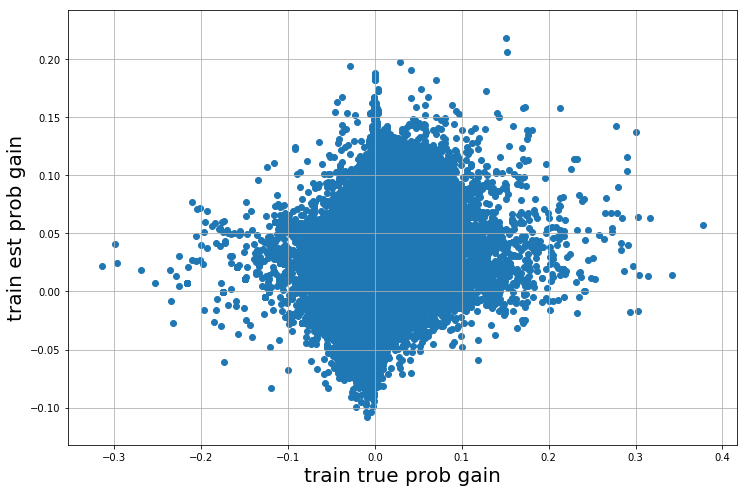

In [37]:
plot_scatter_simple(train_true, train_est * 50, 
                    alpha=0.1, xlabel='train true prob gain', ylabel='train est prob gain')

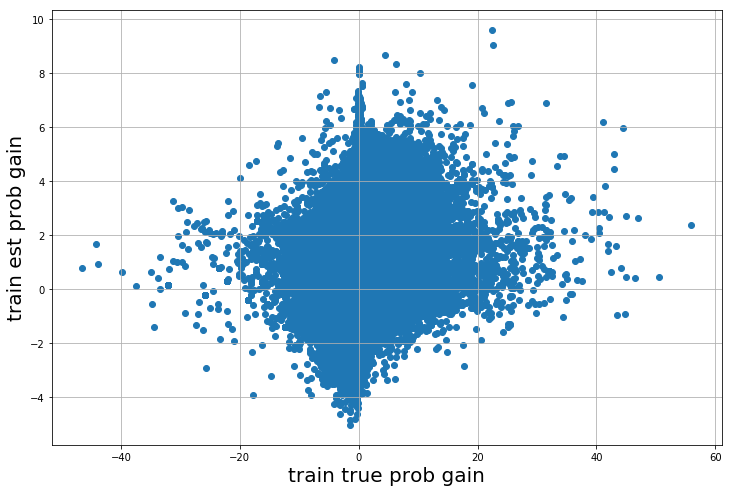

In [43]:
plot_scatter_simple(standerdize(train_true), standerdize(train_est), 
                    alpha=0.1, xlabel='train true prob gain', ylabel='train est prob gain')

# Test

In [ ]:
plot_scatter_simple(test_true, test_est,
                    alpha=0.1, xlabel='test true prob gain', ylabel='test est prob gain')